<a href="https://colab.research.google.com/github/ContextLab/cs-for-psych/blob/master/slides/module_4/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from IPython.display import YouTubeVideo

# Overview

The [HyperTools](https://hypertools.readthedocs.io/en/latest/) Python toolbox provides tools for gaining "geometric insights" into high-dimensional multi-subject datasets.  The overarching idea of the toolbox is to use a series of data processing and visualization approaches to turn a dataset into a 2D or 3D shape or animation that reflects key properties of the original dataset.  This can be a useful way to gain intuitions about a dataset, since our visual systems are adept at identifying complex patterns in visual data.  In this tutorial we will use HyperTools to visualize some neural and behavioral data.


## The HyperTools data visualization pipeline

At its core, the HyperTools toolbox provides a suite of wrappers for myriad functions in the [scikit-learn](https://scikit-learn.org/stable/), [pymvpa](http://www.pymvpa.org/), [braniak](https://brainiak.org/), and [seaborn](https://seaborn.pydata.org/) toolboxes, among others.  A short JMLR paper describing the HyperTools analysis pipeline may be found [here](http://www.jmlr.org/papers/volume18/17-434/17-434.pdf), and a long-form preprint with additional details may be found [here](https://arxiv.org/pdf/1701.08290.pdf).  [This repository](https://github.com/ContextLab/hypertools-paper-notebooks) also contains additional example notebooks.  If you are looking for an alternative introduction to the toolbox with some additional demos, you may be interested in this video:


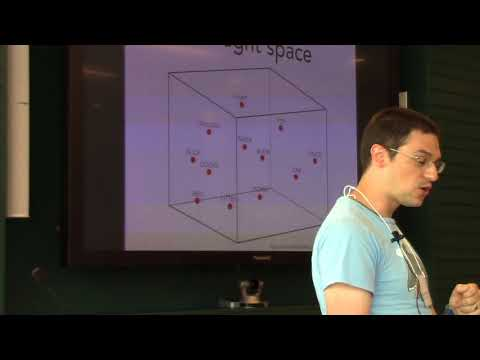

In [7]:
YouTubeVideo('hb_ER9RGtOM')

The **HyperTools data visualization pipeline** defines a set of heuristics for preprocessing a high-dimensional multi-subject dataset and generating a visualization that may be used to gain useful insights into the data.  The idea is to generate visualizable 2D and 3D shapes and animations that reflect key properties of the data.  For example, this visualization displays several participants' unfolding neural patterns as they listen to a 10-minute story (here each line represents the neural activity patterns of a single person):
![](https://hypertools.readthedocs.io/en/latest/_images/hypertools.gif)

The pipeline comprises the following steps:
1. Wrangle the dataset into a list of numerical matrices (*one matrix per subject*).  The matrices' *rows denote timepoints* and their *columns denote features* (a feature may be a voxel, electrode, a word embedding dimension, a label or category, or some other set of observable or quantifiable values).  Note that, for some data types, this wrangling process is non-trivial.  HyperTools incorporates useful functions for [parsing](https://hypertools.readthedocs.io/en/latest/hypertools.tools.format_data.html#hypertools.tools.format_data) a variety of datatypes, including text data.  The [pliers](https://github.com/tyarkoni/pliers) toolbox may also be used to generate HyperTools-compatable feature vectors for a wider range of datatypes.
2. Normalize (*z*-score) within each matrix column to ensure that all dimensions have equal representation in the final visualization.  (This step is optional.)  Pad matrices with columns of zeros as needed, to ensure they all have the same number of columns ($k$).  Note that all matrices must have the same number of rows (number of rows/timepoints: $t$).
3. [Hyperalign](http://haxbylab.dartmouth.edu/publications/HGC+11.pdf) the matrices into a common space.
4. [Embed](https://hypertools.readthedocs.io/en/latest/hypertools.reduce.html#hypertools.reduce) the hyperaligned data into a low-dimensional space (typically this space will be either 2D or 3D).
5. Generate a plot or animation of the reduced data.

If a dataset is stored in the list `data`, the HyperTools pipeline may be used to generate a visualization using a single command:
```
import hypertools as hyp
hyp.plot(data)
```

## Download Sherlock and Paranoia datasets

Follow the instructions [here](http://naturalistic-data.org/features/notebooks/Download_Data.html) to download the Sherlock and Paranoia datasets using DataLad.  In brief, navigate to a directory where you want to save the datasets (let's refer to it as `datadir`) and run the following commands in Terminal:
```
datalad install -g https://gin.g-node.org/ljchang/Sherlock
datalad install -g https://gin.g-node.org/ljchang/Paranoia
```
In the next cell, set the variable `datadir` to the actual path you chose (e.g. `~/data`)

In [17]:
import os
datadir = os.path.join(os.getenv('HOME'), 'data')

# Import libraries

In [115]:
from glob import glob as lsdir
import numpy as np
import pandas as pd
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nilearn.plotting import plot_stat_map

import hypertools as hyp
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# Visual cortex responses while viewing Sherlock

Following the [functional alignment tutorial](http://naturalistic-data.org/features/notebooks/Functional_Alignment.html), we'll select out voxels in early visual cortex from the *Sherlock* dataset.  Then we'll apply the HyperTools pipeline to the dataset and visualize the visual cortex responses as a 3D image.

threshold is ignored for simple axial plots


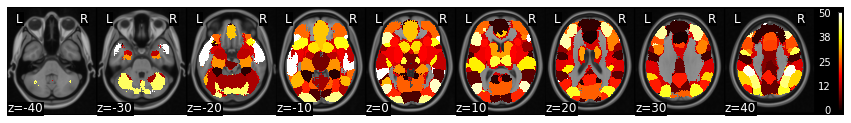

In [24]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
vectorized_mask = expand_mask(mask)
mask.plot()

In [96]:
rois = pd.read_csv('rois.csv', header=None, names=['ID', 'Region'])

In [97]:
rois.head()

,ID,Region
0,0,Anterior MPFC
1,1,Fusiform/parahippocampus
2,2,DMPFC
3,3,Sensorimotor/postcentral gyrus
4,4,V1


threshold is ignored for simple axial plots


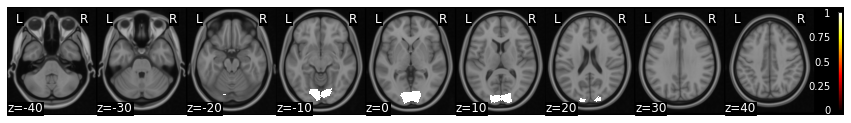

In [98]:
visual_cortex = int(rois.query('Region == "V1"')['ID'])
vectorized_mask[visual_cortex].plot()

threshold is ignored for simple axial plots


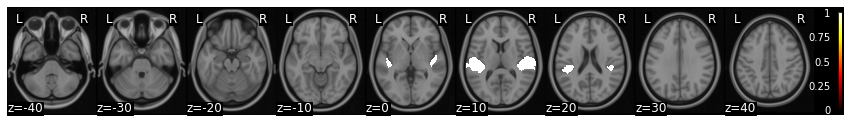

In [99]:
auditory_cortex = int(rois.query('Region == "A1"')['ID'])
vectorized_mask[auditory_cortex].plot()

threshold is ignored for simple axial plots


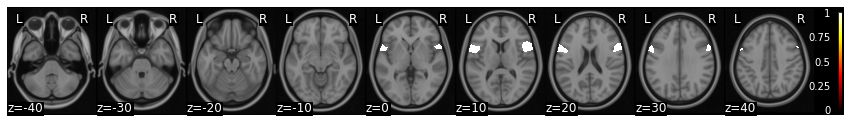

In [100]:
motor_cortex = int(rois.query('Region == "Precentral gyrus"')['ID'])
vectorized_mask[motor_cortex].plot()

In [77]:
def extract_roi_data(fname_template, mask, roi):
    fnames = lsdir(fname_template)
    roi_data = []
    for f in fnames:
        print(f'extracting data for ROI {roi}: ' + f)
        roi_data.append(Brain_Data(f).apply_mask(mask[roi]))
    return roi_data

In [101]:
# define filename templates
sherlock_part1 = os.path.join(datadir, 'Sherlock', 'fmriprep', '*', 'func', '*crop*Part1*hdf5')
sherlock_part2 = os.path.join(datadir, 'Sherlock', 'fmriprep', '*', 'func', '*crop*Part2*hdf5')

In [102]:
rois = {'visual': visual_cortex, 'auditory': auditory_cortex, 'motor': motor_cortex}
parts = {'part 1': sherlock_part1, 'part 2': sherlock_part2}

data = {}
for p in parts.keys():
    roi_data = {}
    for r in rois.keys():
        roi_data[r] = extract_roi_data(parts[p], mask, rois[r])
    data[p] = roi_data

extracting data for ROI 4: /Users/jmanning/data/Sherlock/fmriprep/sub-13/func/sub-13_denoise_crop_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5


OSError: ``/Users/jmanning/data/Sherlock/fmriprep/sub-13/func/sub-13_denoise_crop_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5`` does not exist

# Getting some intuitions for the Sherlock data using HyperTools

## Examining brain responses in visual, auditory, and motor cortex during movie watching

Participants in the Sherlock experiment all watched the same audiovisual movie.  Therefore, to the extent that participants' brain responses were driven by the movie, we might expect that their brain responses in primary auditory and visual cortex should follow similar or related patterns.  In contrast, non-sensory regions like primary motor cortex should not show this sort of agreement.

We can test this intuition qualitatively by projecting the ROI data from visual, auditory, and motor cortex into a shared low-dimensional space.

In [ ]:
hyp.plot(data['part 1']['visual'], align='hyper')

In [ ]:
hyp.plot(data['part 1']['auditory'], align='hyper')

In [ ]:
hyp.plot(data['part 1']['motor'], align='hyper')

Now let's see if these patterns also hold for the second half of the dataset:

In [ ]:
hyp.plot(data['part 2']['visual'], align='hyper')

In [ ]:
hyp.plot(data['part 2']['auditory'], align='hyper')

In [ ]:
hyp.plot(data['part 2']['motor'], align='hyper')

When we visualize high-dimensional data as 3D shapes, we necessarily lose information.  One strategy for getting a better sense of the "true shape" of the data is to use different projection algorithms for embedding the data into the 3D space (this may be done using the `reduce` keyword).

In [ ]:
hyp.plot(data['part 1']['visual'], align='hyper', reduce='UMAP')

In [ ]:
hyp.plot(data['part 1']['visual'], align='hyper', reduce='SpectralEmbedding')

## What is the "shape" of the Sherlock episode?

Following an approach similar to the one used in [this paper](https://www.biorxiv.org/content/10.1101/409987v1), we can use HyperTools to examine how the content of the Sherlock episode unfolds.  First, let's download detailed annotations of the episode to get a sense of what they're like.

In [103]:
def download(source, dest):
    if not os.path.exists(dest):
        stream = urllib.request.urlopen(source)
        data = stream.read()

        with open(dest, 'wb') as fd:
            fd.write(data)

In [104]:
# raw annotations
annotations_source = 'https://github.com/ContextLab/sherlock-topic-model-paper/raw/revision-1/data/raw/Sherlock_Segments_1000_NN_2017.xlsx'
annotations_dest = os.path.join(datadir, 'Sherlock', 'stimuli', 'annotations.xlsx')
download(annotations_source, annotations_dest)
annotations = pd.read_excel(annotations_dest)
annotations.head(3)

,Segment Number,Start Time (s),End Time (s),"Start Time (TRs, 1.5s)","End Time (TRs, 1.5s)",Scene Segments,Scene Details - A Level,Space-In/Outdoor,Name - All,Name - Focus,...,Music Presence,Words on Screen,Arousal - Rater 1,Valence - Rater 1,Arousal - Rater 2,Valence - Rater 2,Arousal - Rater 3,Valence - Rater 3,Arousal - Rater 4,Valence - Rater 4
0,1,0,12,1.0,8.0,1. Cartoon,"People in popcorn, candy, and soft drink costu...",Indoor,Cartoon People in Costumes,Cartoon People in Costumes,...,Yes,NaN,3,+,1,+,2,+,3,+
1,2,12,15,9.0,10.0,NaN,Popcorn is being popped in a large popcorn mac...,Indoor,Female Singer,NaN,...,Yes,NaN,3,+,1,+,2,+,2,+
2,3,15,17,11.0,11.0,NaN,"Men sing in reply: ""the popcorn can't be beat!""",Indoor,Male Singers,NaN,...,Yes,NaN,3,+,1,+,2,+,2,+


Next, we'll preprocess the anotations in sliding windows of (up to) 50 segments.  In each sliding window, we'll concatenate all of the text into a single "blob" that merges all of the columns of the annotation spreadsheet, from all of the segments in that window.  Note that the preprocessing was carried out using the code in [this notebook](https://github.com/ContextLab/sherlock-topic-model-paper/blob/revision-1/code/notebooks/main/topic_model_analysis.ipynb); here we'll be downloading the resulting preprocessed text rather than reproducing it.

In [105]:
# preprocessed annotations
preprocessed_source = 'https://github.com/ContextLab/sherlock-topic-model-paper/raw/revision-1/data/processed/video_text.npy'
preprocessed_dest = os.path.join(datadir, 'Sherlock', 'stimuli', 'video_text.npy')
download(source, dest)

text = np.load(dest)

Let's examine the text in a window somewhere near the middle:

In [109]:
text[500][:250] + '...'

'sherlock takes a deep breath through his nose outdoor sherlock donovan sherlock lauriston gardens  street  over the shoulder medium no sherlock i even know you didnt make it home last night outdoor sherlock donovan sherlock sherlock lauriston gardens...'

Next, we'll use HyperTools to train a topic model ([Blei et al., 2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)) on the annotations, treating the text in each sliding window as a document.  We'll plot the result as a 3D shape.

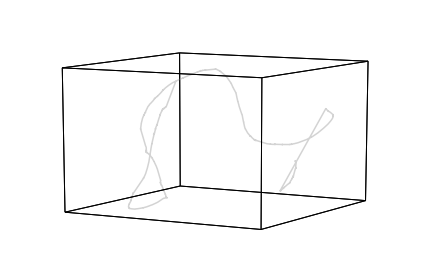

In [141]:
text_geometry = hyp.plot(text, reduce='UMAP', color='lightgray')

We can also visualize the timecourse of word embeddings for the movie as a heatmap.  Since we've already fit our topic model to the annotation text, HyperTools automatically uses the cached result (so the command runs quickly).  Here each row is a timepoint and each column is a topic dimension (i.e., a word embedding dimension):

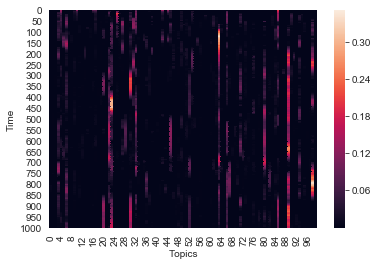

In [144]:
topics = hyp.tools.format_data(text)[0]
h = sns.heatmap(topics)
h.set_xlabel('Topics');
h.set_ylabel('Time');

- train topic model on sherlock annotations
- create movie trajectory
- compare it to the shape of the average trajectory in visual/auditory/motor cortex
- link to sherlock paper repo for more info